In [1]:
!pip install ultralytics albumentations==1.3.0 timm==0.9.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.5 MB/s eta 0:00:00


In [2]:
# -*- coding: utf-8 -*-
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import mean_absolute_error
import random
import matplotlib.pyplot as plt
import seaborn as sns


os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'


In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed(worker_seed)

seed_everything(SEED)

In [33]:
data = pd.read_csv('/kaggle/input/lacuna-solar-survey-challenge/Train.csv')
test = pd.read_csv('/kaggle/input/lacuna-solar-survey-challenge/Test.csv')

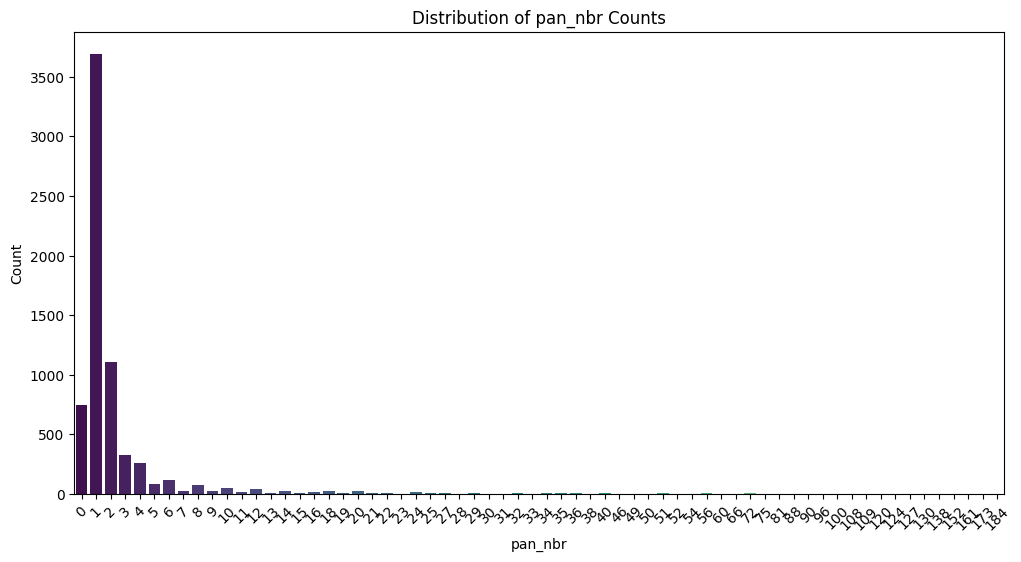

In [34]:
pan_nbr_counts = data['pan_nbr'].value_counts().sort_index()  # or sort by frequency with `.sort_values()`
plt.figure(figsize=(12, 6))
sns.barplot(x=pan_nbr_counts.index, y=pan_nbr_counts.values, palette='viridis')
plt.title('Distribution of pan_nbr Counts')
plt.xlabel('pan_nbr')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [36]:
import ast

for idx,row in data.iterrows():
    # Parse the polygon string into a list of tuples
    try:
        polygon = ast.literal_eval(row['polygon'])
    except (SyntaxError, ValueError):
        print(f"Invalid polygon format at index {idx}")
        continue
    invalid_found = False
    for point in polygon:
        x, y = point
        # Check if x or y are strings containing letters
        if isinstance(x, str) and any(c.isalpha() for c in x):
            invalid_found = True
            print(x)
            break
        if isinstance(y, str) and any(c.isalpha() for c in y):
            invalid_found = True
            print(y)
            break
    
    if invalid_found:
        print(f"Row {idx} has invalid coordinates in its polygon")

Invalid polygon format at index 4031
6707z2
Row 5385 has invalid coordinates in its polygon


In [37]:
data.iloc[5385, data.columns.get_loc('polygon')] = "[(2250, 3318.0), (1639, 3334.0), (1707.2, 3334.0), (1642, 3233.0), (2248, 3221.0)]"
data = data.drop(index=4031)
data = data.reset_index(drop=True)

5280


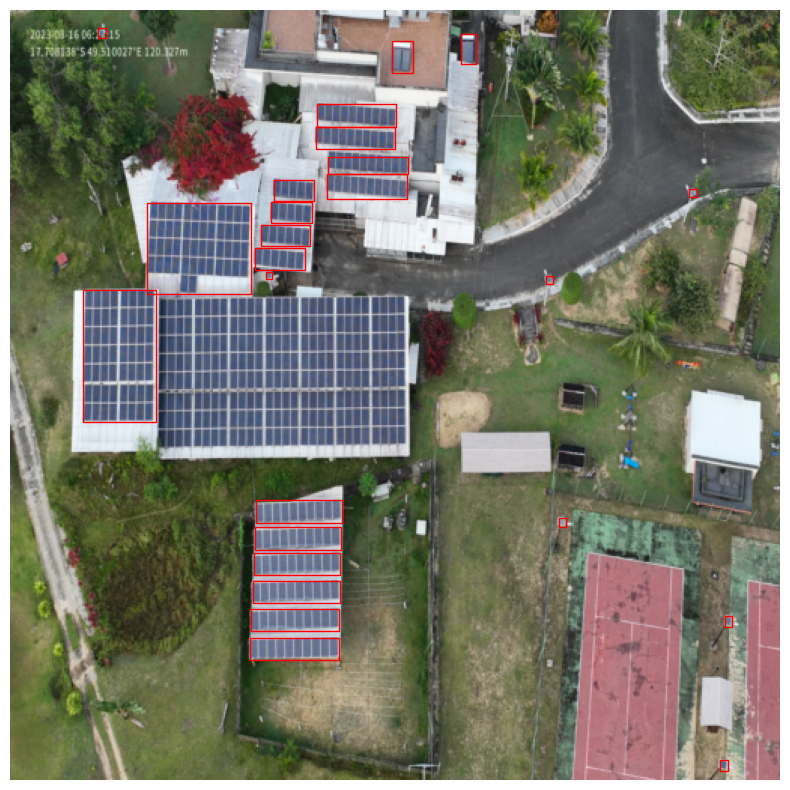

In [40]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib.patches as patches
import ast

# Define transforms
transforms = T.Compose([
    T.ToTensor(),          # Convert OpenCV numpy array to tensor (C, H, W)
    T.Resize((512, 512)),
])

# Load image and polygon data
img_id = "IDmfKSa"  # Change this to test different IDs
img_path = os.path.join("/kaggle/input/lacuna-solar-survey-challenge/images/", img_id + '.jpg')

# Load and convert image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_height, original_width = img.shape[:2]

# Apply transforms
transformed_img = transforms(img)  # Shape: (3, 512, 512)

# Convert tensor to numpy (do this ONCE)
def tensor_to_numpy(img_tensor):
    img_np = img_tensor.numpy().transpose(1, 2, 0) * 255
    return img_np.astype(np.uint8)

# Create figure and plot base image ONCE
plt.figure(figsize=(10, 10))
plt.imshow(tensor_to_numpy(transformed_img))
ax = plt.gca()

# Extract all polygons for this image
polygons = []
for row in data[data["ID"] == img_id]['polygon']:
    polygons.append(ast.literal_eval(row))  # Handle multiple polygon entries
# Calculate scaling factors
scale_width = 512 / original_width
scale_height = 512 / original_height
# Process all polygons
def polygon_to_box(poly):
    x_coords = [x for (x, y) in poly]
    y_coords = [y for (x, y) in poly]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

for original_polygon in polygons:
    # Scale coordinates
    scaled_polygon = [(x * scale_width, y * scale_height) for (x, y) in original_polygon]
    # Convert to bounding box
    scaled_bbox = polygon_to_box(scaled_polygon)
    
    # Create and add rectangle patch
    rect = patches.Rectangle(
        (scaled_bbox[0], scaled_bbox[1]),
        scaled_bbox[2] - scaled_bbox[0],
        scaled_bbox[3] - scaled_bbox[1],
        linewidth=1, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)  # Add to existing axes

plt.axis('off')
plt.show()

In [41]:
class SolarPanelDataset(Dataset):
    def __init__(self, dataframe, transform=None, to_train=True, cache_images=True):
        self.dataframe = dataframe
        self.transform = transform
        self.to_train = to_train
        self.placement_map = {"roof": 0, "openspace": 1, "r_openspace": 2, "S-unknown": 3}
        
        # Cache images during initialization and resize to 1280*720
        self.images = {}
        if cache_images:
            print("Caching images...")
            for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
                try:
                    image = cv2.imread(row["path"])
                    if image is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        self.images[row['ID']] = cv2.resize(image, (1280,720))
                    else:
                        print(f"Warning: Unable to read image at {row['path']}")
                except Exception as e:
                    print(f"Error loading image at index {idx}: {e}")
            
            print(f"Successfully cached {len(self.images)} out of {len(dataframe)} images")
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        image = self.images[row['ID']]
        # Improved metadata encoding
        metadata = torch.zeros(5)
        metadata[0] = 1.0 if row["img_origin"] == "D" else 0.0
        placement = self.placement_map.get(row["placement"], 3)
        metadata[1 + placement] = 1.0  # One-hot encoding
        if self.transform:
            image = self.transform(image=image)['image']
        if self.to_train:
            target = torch.tensor([row["boil_nbr"], row["pan_nbr"]], dtype=torch.float32)
            return image, metadata, target
        return image, metadata

In [42]:
class EfficientNetV2Meta(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_b3", pretrained=True, num_classes=0)  # Larger backbone
        self.meta_processor = nn.Sequential(
            nn.Linear(5, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64)
        )
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=4)
        self.regressor = nn.Sequential(
            nn.Linear(self.backbone.num_features + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2),
            nn.Softplus()  # Better for count predictions
        )

    def forward(self, image, metadata):
        img_features = self.backbone(image)
        meta_features = self.meta_processor(metadata.unsqueeze(0))
        attn_output, _ = self.attention(meta_features, meta_features, meta_features)
        combined = torch.cat([img_features, attn_output.squeeze(0)], dim=1)
        return self.regressor(combined)

In [43]:
# Advanced Augmentation
train_transform = A.Compose([
    A.RandomResizedCrop(512, 512, scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.CLAHE(clip_limit=4.0, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [44]:
# Training Configuration
def train(fold=0, epochs=20, batch_size=16):
    train_df = data
    train_df = train_df.groupby("ID").agg({
        "boil_nbr": "sum",
        "pan_nbr": "sum",
        "img_origin": "first",
        "placement": "first"
    }).reset_index()
    train_df["path"] = "/kaggle/input/lacuna-solar-survey-challenge/images/" + train_df["ID"] + ".jpg"

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(kf.split(train_df))
    train_idx, val_idx = splits[fold]

    train_ds = SolarPanelDataset(train_df.iloc[train_idx], transform=train_transform)
    val_ds = SolarPanelDataset(train_df.iloc[val_idx], transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, 
                             shuffle=True, num_workers=4, pin_memory=True,worker_init_fn=seed_worker)
    val_loader = DataLoader(val_ds, batch_size=batch_size*2, 
                           shuffle=False, num_workers=4, pin_memory=True,worker_init_fn=seed_worker)

    model = EfficientNetV2Meta().cuda()
    criterion = nn.HuberLoss(delta=1.0)  # Improved loss function
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler = GradScaler()

    best_mae = float('inf')
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, meta, targets in pbar:
            images = images.cuda(non_blocking=True)
            meta = meta.cuda(non_blocking=True)
            targets = targets.cuda(non_blocking=True)
            
            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                outputs = model(images, meta)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        preds, truths = [], []
        with torch.no_grad():
            for images, meta, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images = images.cuda(non_blocking=True)
                meta = meta.cuda(non_blocking=True)
                targets = targets.cuda(non_blocking=True)
                
                with autocast(device_type='cuda'):
                    outputs = model(images, meta)
                    loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                preds.append(outputs.cpu().numpy())
                truths.append(targets.cpu().numpy())
        
        # Metrics calculation
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        preds = np.concatenate(preds)
        truths = np.concatenate(truths)
        mae = mean_absolute_error(truths, preds)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {mae:.4f}")
        
        # Model checkpointing based on MAE
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), f"best_model_fold{fold}.pth")
        
        scheduler.step()
    
    return best_mae

In [ ]:
# Inference with TTA
def predict(test_df, model_paths, batch_size=32):
    test_df["path"] = "/kaggle/input/lacuna-solar-survey-challenge/images/" + test_df["ID"] + ".jpg"
    test_ds = SolarPanelDataset(test_df, transform=test_transform, to_train=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)
    
    predictions = np.zeros((len(test_df), 2))
    for path in model_paths:
        model = EfficientNetV2Meta().cuda()
        model.load_state_dict(torch.load(path, weights_only=True))  # Safer loading
        model.eval()
        
        tta_preds = []
        with torch.no_grad():
            for images, meta in tqdm(test_loader, desc="Inference"):
                images = images.cuda()
                meta = meta.cuda()
                with autocast(device_type='cuda'):
                    outputs = model(images, meta)
                tta_preds.append(outputs.cpu().numpy())
        
        predictions += np.concatenate(tta_preds)
    
    return predictions / len(model_paths)


In [45]:

# Main Execution
if __name__ == "__main__":
    # Train multiple folds
    folds = 3
    model_paths = []
    for fold in range(folds):
        print(f"Training fold {fold+1}/{folds}")
        best_mae = train(fold=fold, epochs=52, batch_size=16)
        model_paths.append(f"best_model_fold{fold}.pth")
    
    # Prepare submission
    test_df = pd.read_csv("/kaggle/input/lacuna-solar-survey-challenge/Test.csv")
    predictions = predict(test_df, model_paths, batch_size=64)
    
    # Create submissions
    submission = pd.DataFrame({
        "ID": np.repeat(test_df["ID"].values, 2),
        "Target": predictions.flatten()
    })
    submission["ID"] += np.where(
        submission.groupby("ID").cumcount() == 0,
        "_boil",
        "_pan"
    )
    submission.to_csv("submission_original2.csv", index=False)
    
    int_submission = submission.copy()
    int_submission["Target"] = np.round(int_submission["Target"]).astype(int)
    int_submission.to_csv("submission_integer2.csv", index=False)
    
    print("Submissions saved with shapes:", submission.shape, int_submission.shape)

Training fold 1/3
Caching images...


  3%|▎         | 79/2649 [00:11<06:22,  6.73it/s]


KeyboardInterrupt: 